In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from torch.autograd import Variable
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
import os

In [53]:
torch.manual_seed(9)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Resize(32), 
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.CIFAR10("./cifar10", download=True, train=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified


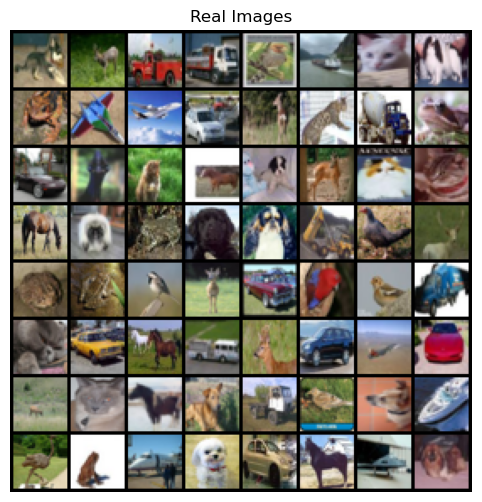

In [56]:
real_image_batch = next(iter(data_loader))
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_image_batch[0].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [74]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.emb = nn.Embedding(10, 100)
        self.fc = nn.Linear(100, 128 * 8 ** 2)
        self.main = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        x = self.emb(labels) * noise
        x = self.fc(x)
        x = x.view(-1, 128, 8, 8)
        x = self.main(x)
        return x


In [75]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )

        self.validity_layer = nn.Sequential(nn.Linear(128 * 2 * 2, 1), nn.Sigmoid())
        self.label_layer = nn.Sequential(nn.Linear(128 * 2 * 2, 10), nn.Softmax())

    def forward(self, img):
        features = self.feature_extractor(img)
        features = features.view(features.size(0), -1)
        validity = self.validity_layer(features)
        label = self.label_layer(features)
        return validity, label


In [76]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

In [77]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

initialize_weights(generator)
initialize_weights(discriminator)

In [78]:
if not os.path.exists('Results/ACGAN_FAKE'):
    os.makedirs('Results/ACGAN_FAKE')
if not os.path.exists('Results/ACGAN_REAL'):
    os.makedirs('Results/ACGAN_REAL')

In [79]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx])
inception_model = inception_model.to(device)

In [80]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [81]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [82]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [83]:
gen_loss_arr = []
disc_loss_arr = []
fake_image = []
real_image = []
FID_arr = []

def train(generator, discriminator, dataloader, epochs):    
    optimG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))
    optimD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))
    source_criterion = nn.BCELoss()
    class_criterion = nn.NLLLoss()
    
    generator.train()
    discriminator.train()
    
    for epoch in range(epochs):
        
        batch_gen_loss = []
        batch_disc_loss = []
        real_images = None
        fake_images = None
        
        for idx, (real_images, real_labels) in enumerate(dataloader, 0):
            real_labels = real_labels.to(device)
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            fake = torch.zeros(batch_size).to(device)
            valid = torch.ones(batch_size).to(device)
                    
            optimD.zero_grad()
            z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (batch_size, 100))))
            generated_labels = Variable(torch.cuda.LongTensor(np.random.randint(0, 10, batch_size)))
            generated_images = generator(z, generated_labels)
            real_pred, real_aux = discriminator(real_images)
            disc_loss_real = 0.5 * (source_criterion(real_pred, valid.unsqueeze(1)) + class_criterion(real_aux, real_labels))
            
            fake_pred, fake_aux = discriminator(generated_images.detach())
            disc_loss_fake = 0.5 * (source_criterion(fake_pred, fake.unsqueeze(1)) + class_criterion(fake_aux, generated_labels))
            disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
            disc_loss.backward()
            optimD.step()
            batch_disc_loss.append(disc_loss.item())    
            
            optimG.zero_grad()  
            validity, predicted_label = discriminator(generated_images)
            gen_loss = 0.5 * (source_criterion(validity, valid.unsqueeze(1)) + class_criterion(predicted_label, generated_labels))
            gen_loss.backward()
            optimG.step()
            batch_gen_loss.append(gen_loss.item())
            
        
            if idx % 100 == 0 or epoch==epochs:
                print(f"Epoch [{epoch}/{epochs}], Step [{idx}/{len(dataloader)}], "
                      f"Discriminator Loss: {disc_loss.item()}, Generator Loss: {gen_loss.item()}")
        
        with torch.no_grad():
            z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (batch_size, 100))))
            generated_labels = Variable(torch.cuda.LongTensor(np.random.randint(0, 10, batch_size)))
            fake_images = generator(z, generated_labels)
            fakeimg_grid = torchvision.utils.make_grid(fake_images.detach().cpu(), padding=2, normalize=True)
            real_images_grid = torchvision.utils.make_grid(real_images.detach().cpu(), padding=2, normalize=True)
            fake_image.append(fakeimg_grid)
            real_image.append(real_images_grid)
            #Save images
            utils.save_image(fakeimg_grid,'./Results/ACGAN_FAKE/ACGAN_epoch_%03d.png' % (epoch), normalize = True)
            utils.save_image(real_images_grid,'./Results/ACGAN_REAL/ACGAN_epoch_%03d.png' % (epoch), normalize = True)
            
        gen_loss_arr.append(np.mean(batch_gen_loss))
        disc_loss_arr.append(np.mean(batch_disc_loss))
        
        #Cal FID
        fretchet_dist=calculate_fretchet(real_images, fake_images, inception_model)
        FID_arr.append(fretchet_dist)
        print(f"FID value at epoch{epoch}/{epochs} is {fretchet_dist}")

In [84]:
train(generator, discriminator, data_loader, 50)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x200 and 110x128)

In [68]:
if not os.path.exists('Results/FID'):
       os.makedirs('Results/FID')
np.save('Results/ACGAN_FID', FID_arr) 

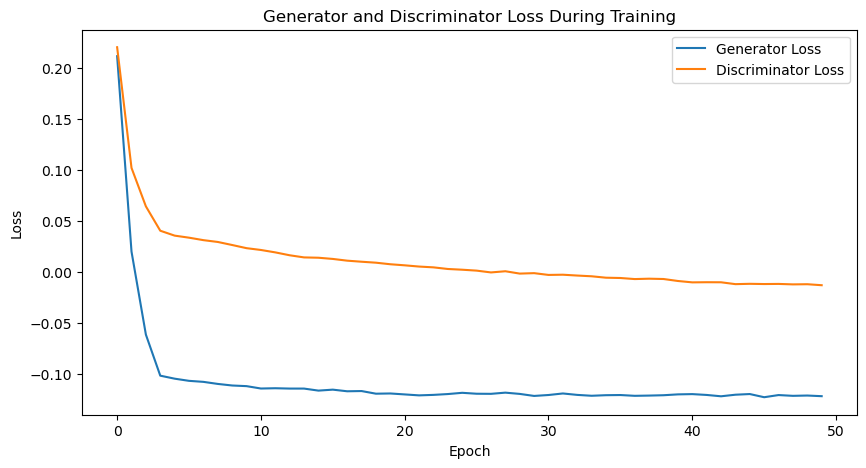

In [69]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_loss_arr, label="Generator Loss")
plt.plot(disc_loss_arr, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

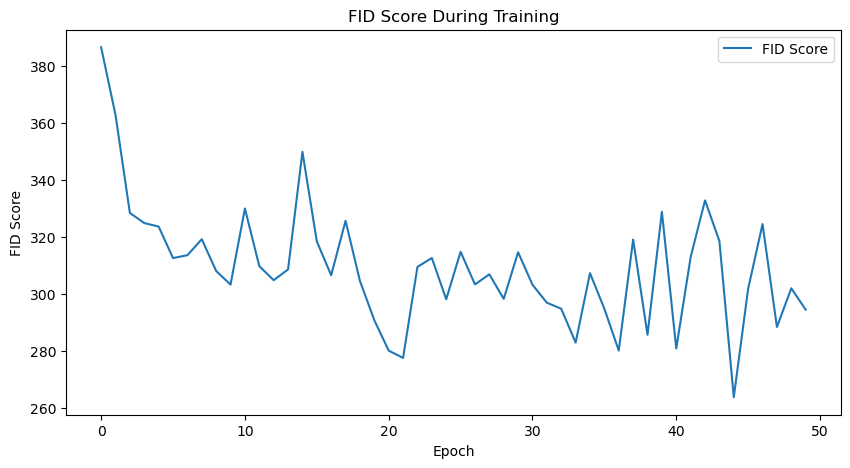

In [70]:
plt.figure(figsize=(10, 5))
plt.title("FID Score During Training")
plt.plot(FID_arr, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

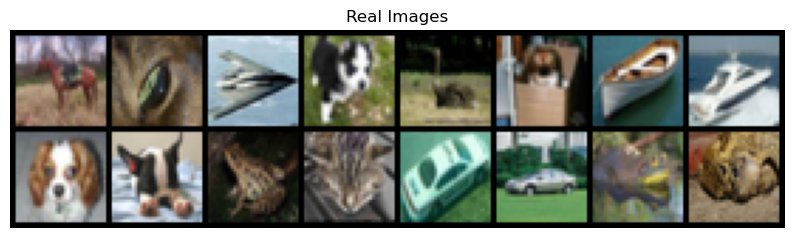

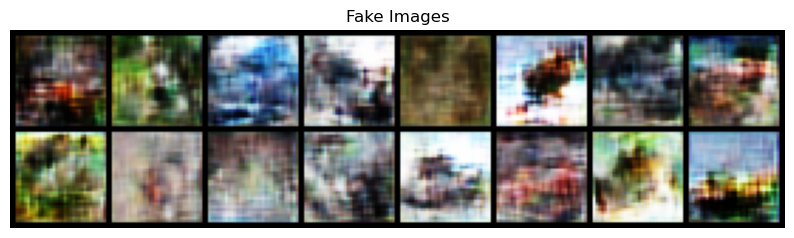

In [71]:
#real
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_image[-1], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()


# fake 
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(utils.make_grid(fake_image[-1], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()